# KEN3450, Data Analysis 2020 

**Kaggle Competition 2020**<br>

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import math
import re
import os
import graphviz
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
#import your classifiers here

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.max_rows = 500
pd.options.display.max_columns = 500
# References https://stackoverflow.com/questions/46543060/how-to-replace-every-nan-in-a-column-with-different-random-values-using-pandas

# Diagnosing the Maastricht Flu 

You are given the early data for an outbreak of a dangerous virus originating from a group of primates being kept in a Maastricht biomedical research lab in the basement of Henri-Paul Spaaklaan building, this virus is dubbed the "Maastricht Flu".

You have the medical records of $n$ number of patients in `flu_train.csv`. There are two general types of patients in the data, flu patients and healthy (this is recorded in the column labeled `flu`, a 0 indicates the absences of the virus and a 1 indicates presence). Notice that the dataset is unbalanced and you can expect a similar imbalance in the testing set.

**Your task:** build a model to predict if a given patient has the flu. Your goal is to catch as many flu patients as possible without misdiagnosing too many healthy patients.

**The deliverable:** submit your final solution via Kaggle competition using the `flu_test.csv` data.

Maastricht Gemeente will use your model to diagnose sets of future patients (held by us). You can expect that there will be an increase in the number of flu patients in any groups of patients in the future.

Here are some benchmarks for comparison and for expectation management. Notice that because the dataset is unbalanced, we expect that there is going to be a large difference in the accuracy for each class, thus `accuracy` is a metric that might be misleading in this case (see also below). That's why the baselines below are based on the expected accuracy **per class** and also they give you an estimate for the AUROC on all patients in the testing data. This is the score you see in the Kaggle submission as well.

**Baseline Model:** 
- ~50% expected accuracy on healthy patients in training data
- ~50% expected accuracy on flu patients in training data
- ~50% expected accuracy on healthy patients in testing data (future data, no info on the labels)
- ~50% expected accuracy on flu patients in testing data (future data, no info on the labels)
- ~50% expected AUROC on all patients in testing data (future data, no info on the labels)

**Reasonable Model:** 
- ~70% expected accuracy on healthy patients in training data
- ~55% expected accuracy on flu patients, in training data
- ~70% expected accuracy on healthy patients in testing data (future data, no info on the labels, to be checked upon your submission)
- ~57% expected accuracy on flu patients, in testing data (future data, no info on the labels, to be checked upon your submission)
- ~65% expected AUROC on all patients, in testing data (future data, no info on the labels, to be checked from Kaggle)

**Grading:**
Your grade will be based on:
1. your model's ability to out-perform the benchmarks (they are kind of low, so we won't care much about this)
2. your ability to carefully and thoroughly follow the data analysis pipeline
3. the extend to which all choices are reasonable and defensible by methods you have learned in this class

## Step 1: Read the data, clean and explore the data

There are a large number of missing values in the data. Nearly all predictors have some degree of missingness. Not all missingness are alike: NaN in the `'pregnancy'` column is meaningful and informative, as patients with NaN's in the pregnancy column are males, where as NaN's in other predictors may appear randomly. 


**What do you do?:** We make no attempt to interpret the predictors and we make no attempt to model the missing values in the data in any meaningful way. We replace all missing values with 0.

However, it would be more complete to look at the data and allow the data to inform your decision on how to address missingness. For columns where NaN values are informative, you might want to treat NaN as a distinct value; You might want to drop predictors with too many missing values and impute the ones with few missing values using a model. There are many acceptable strategies here, as long as the appropriateness of the method in the context of the task and the data is discussed.

In [2]:
np.random.seed(0)
def fillNaN_with_unifrand(df):
    a = df.values
    m = np.isnan(a) # mask of NaNs
    mu, sigma = df.mean(), df.std()
    a[m] = np.random.normal(mu, sigma, size=m.sum())
    return df

In [3]:
def clean_train(df):
    df_cleaned_train = df.copy()

    # Changed Male/Female to 1/0 for a boolean datatype
    df_cleaned_train.loc[(df_cleaned_train['Gender'] == 'male'), 'Gender'] = 1
    df_cleaned_train.loc[(df_cleaned_train['Gender'] == 'female'), 'Gender'] = 0
    df_cleaned_train.dropna(subset=['Gender'], inplace=True)

    # Age of 0 is okay, we assume this are babies.
    #display(df_cleaned_train[df_cleaned_train['Age'] == 0]['Weight'].describe())


    # Set everybody under age of 14 to No Degree
    df_cleaned_train.loc[(pd.isna(df_cleaned_train['Education'])) & (df_cleaned_train['Age'] < 14), 'Education'] = 'No Degree'
    df_cleaned_train.loc[(pd.isna(df_cleaned_train['Education'])), 'Education'] = 'Unknown'

    # Set Marital Status to unknown for the missing values
    df_cleaned_train.loc[(pd.isna(df_cleaned_train['MaritalStatus'])), 'MaritalStatus'] = 'Unknown'

    # Delete all rows where HHIncome is nan
    df_cleaned_train.dropna(subset=['HHIncomeMid'], inplace=True)

    #df_cleaned_train[pd.isna(df_cleaned_train['Poverty'])]
    #df_cleaned_train.plot.scatter(y = 'Poverty', x='HHIncomeMid')
    # Deleting missing poverty values for now, if it is import we can do a lin reg later on.
    df_cleaned_train.loc[(df_cleaned_train['Poverty'] == 0) & (df_cleaned_train['HHIncome'] == 'more 99999'), 'Poverty'] = math.nan
    df_cleaned_train.dropna(subset=['Poverty'], inplace=True)

    del df_cleaned_train['HHIncome']
    #display(df_cleaned_train[df_cleaned_train['Poverty'] == 0])


    df_cleaned_train.dropna(subset=['HomeRooms'], inplace=True)
    df_cleaned_train.dropna(subset=['HomeOwn'], inplace=True)
    df_cleaned_train.loc[(pd.isna(df_cleaned_train['Work'])), 'Work'] = 'Unknown'
    df_cleaned_train.loc[(pd.isna(df_cleaned_train['Weight'])) & (df_cleaned_train.flu == 1), 'Weight'] = fillNaN_with_unifrand(df_cleaned_train[df_cleaned_train.flu == 1]['Weight'])
    df_cleaned_train.loc[(pd.isna(df_cleaned_train['Weight'])) & (df_cleaned_train.flu == 0), 'Weight'] = fillNaN_with_unifrand(df_cleaned_train[df_cleaned_train.flu == 0]['Weight'])


    # Height and Length describe the same values, so we copy it from one to the other.
    df_cleaned_train.loc[((pd.notna(df_cleaned_train.Length)) & (pd.isna(df_cleaned_train.Height))), 'Height'] = df_cleaned_train[(pd.notna(df_cleaned_train.Length)) & (pd.isna(df_cleaned_train.Height))][['Length']]
    df_cleaned_train.dropna(subset=['Height'], inplace=True)
    del df_cleaned_train['Length']

    del df_cleaned_train['HeadCirc']
    del df_cleaned_train['BMICatUnder20yrs']
    del df_cleaned_train['BMI_WHO']
    df_cleaned_train.dropna(subset=['BMI'], inplace=True)

    df_cleaned_train.loc[(pd.isna(df_cleaned_train['Pulse'])) & (df_cleaned_train.flu == 1), 'Pulse'] = fillNaN_with_unifrand(df_cleaned_train[df_cleaned_train.flu == 1]['Pulse'])
    df_cleaned_train.loc[(pd.isna(df_cleaned_train['Pulse'])) & (df_cleaned_train.flu == 0), 'Pulse'] = fillNaN_with_unifrand(df_cleaned_train[df_cleaned_train.flu == 0]['Pulse'])

    df_cleaned_train.loc[(pd.isna(df_cleaned_train['BPSysAve'])) & (df_cleaned_train.flu == 1), 'BPSysAve'] = fillNaN_with_unifrand(df_cleaned_train[df_cleaned_train.flu == 1]['BPSysAve'])
    df_cleaned_train.loc[(pd.isna(df_cleaned_train['BPSysAve'])) & (df_cleaned_train.flu == 0), 'BPSysAve'] = fillNaN_with_unifrand(df_cleaned_train[df_cleaned_train.flu == 0]['BPSysAve'])

    df_cleaned_train.loc[(pd.isna(df_cleaned_train['BPDiaAve'])) & (df_cleaned_train.flu == 1), 'BPDiaAve'] = fillNaN_with_unifrand(df_cleaned_train[df_cleaned_train.flu == 1]['BPDiaAve'])
    df_cleaned_train.loc[(pd.isna(df_cleaned_train['BPDiaAve'])) & (df_cleaned_train.flu == 0), 'BPDiaAve'] = fillNaN_with_unifrand(df_cleaned_train[df_cleaned_train.flu == 0]['BPDiaAve'])

    df_cleaned_train.loc[(pd.isna(df_cleaned_train['BPSys1'])) & (df_cleaned_train.flu == 1), 'BPSys1'] = fillNaN_with_unifrand(df_cleaned_train[df_cleaned_train.flu == 1]['BPSys1'])
    df_cleaned_train.loc[(pd.isna(df_cleaned_train['BPSys1'])) & (df_cleaned_train.flu == 0), 'BPSys1'] = fillNaN_with_unifrand(df_cleaned_train[df_cleaned_train.flu == 0]['BPSys1'])

    df_cleaned_train.loc[(pd.isna(df_cleaned_train['BPDia1'])) & (df_cleaned_train.flu == 1), 'BPDia1'] = fillNaN_with_unifrand(df_cleaned_train[df_cleaned_train.flu == 1]['BPDia1'])
    df_cleaned_train.loc[(pd.isna(df_cleaned_train['BPDia1'])) & (df_cleaned_train.flu == 0), 'BPDia1'] = fillNaN_with_unifrand(df_cleaned_train[df_cleaned_train.flu == 0]['BPDia1'])

    df_cleaned_train.loc[(pd.isna(df_cleaned_train['BPSys2'])) & (df_cleaned_train.flu == 1), 'BPSys2'] = fillNaN_with_unifrand(df_cleaned_train[df_cleaned_train.flu == 1]['BPSys2'])
    df_cleaned_train.loc[(pd.isna(df_cleaned_train['BPSys2'])) & (df_cleaned_train.flu == 0), 'BPSys2'] = fillNaN_with_unifrand(df_cleaned_train[df_cleaned_train.flu == 0]['BPSys2'])

    df_cleaned_train.loc[(pd.isna(df_cleaned_train['BPDia2'])) & (df_cleaned_train.flu == 1), 'BPDia2'] = fillNaN_with_unifrand(df_cleaned_train[df_cleaned_train.flu == 1]['BPDia2'])
    df_cleaned_train.loc[(pd.isna(df_cleaned_train['BPDia2'])) & (df_cleaned_train.flu == 0), 'BPDia2'] = fillNaN_with_unifrand(df_cleaned_train[df_cleaned_train.flu == 0]['BPDia2'])

    df_cleaned_train.loc[(pd.isna(df_cleaned_train['BPSys3'])) & (df_cleaned_train.flu == 1), 'BPSys3'] = fillNaN_with_unifrand(df_cleaned_train[df_cleaned_train.flu == 1]['BPSys3'])
    df_cleaned_train.loc[(pd.isna(df_cleaned_train['BPSys3'])) & (df_cleaned_train.flu == 0), 'BPSys3'] = fillNaN_with_unifrand(df_cleaned_train[df_cleaned_train.flu == 0]['BPSys3'])

    df_cleaned_train.loc[(pd.isna(df_cleaned_train['BPDia3'])) & (df_cleaned_train.flu == 1), 'BPDia3'] = fillNaN_with_unifrand(df_cleaned_train[df_cleaned_train.flu == 1]['BPDia3'])
    df_cleaned_train.loc[(pd.isna(df_cleaned_train['BPDia3'])) & (df_cleaned_train.flu == 0), 'BPDia3'] = fillNaN_with_unifrand(df_cleaned_train[df_cleaned_train.flu == 0]['BPDia3'])

    df_cleaned_train.Testosterone = df_cleaned_train.Testosterone.astype(float)
    df_cleaned_train.loc[(pd.isna(df_cleaned_train['Testosterone'])) & (df_cleaned_train.flu == 1), 'Testosterone'] = fillNaN_with_unifrand(df_cleaned_train[df_cleaned_train.flu == 1]['Testosterone'])
    df_cleaned_train.loc[(pd.isna(df_cleaned_train['Testosterone'])) & (df_cleaned_train.flu == 0), 'Testosterone'] = fillNaN_with_unifrand(df_cleaned_train[df_cleaned_train.flu == 0]['Testosterone'])

    df_cleaned_train.loc[(pd.isna(df_cleaned_train['DirectChol'])) & (df_cleaned_train.flu == 1), 'DirectChol'] = fillNaN_with_unifrand(df_cleaned_train[df_cleaned_train.flu == 1]['DirectChol'])
    df_cleaned_train.loc[(pd.isna(df_cleaned_train['DirectChol'])) & (df_cleaned_train.flu == 0), 'DirectChol'] = fillNaN_with_unifrand(df_cleaned_train[df_cleaned_train.flu == 0]['DirectChol'])

    df_cleaned_train.loc[(pd.isna(df_cleaned_train['TotChol'])) & (df_cleaned_train.flu == 1), 'TotChol'] = fillNaN_with_unifrand(df_cleaned_train[df_cleaned_train.flu == 1]['TotChol'])
    df_cleaned_train.loc[(pd.isna(df_cleaned_train['TotChol'])) & (df_cleaned_train.flu == 0), 'TotChol'] = fillNaN_with_unifrand(df_cleaned_train[df_cleaned_train.flu == 0]['TotChol'])

    df_cleaned_train.loc[(pd.isna(df_cleaned_train['UrineVol1'])) & (df_cleaned_train.flu == 1), 'UrineVol1'] = fillNaN_with_unifrand(df_cleaned_train[df_cleaned_train.flu == 1]['UrineVol1'])
    df_cleaned_train.loc[(pd.isna(df_cleaned_train['UrineVol1'])) & (df_cleaned_train.flu == 0), 'UrineVol1'] = fillNaN_with_unifrand(df_cleaned_train[df_cleaned_train.flu == 0]['UrineVol1'])

    df_cleaned_train.loc[(pd.isna(df_cleaned_train['UrineFlow1'])) & (df_cleaned_train.flu == 1), 'UrineFlow1'] = fillNaN_with_unifrand(df_cleaned_train[df_cleaned_train.flu == 1]['UrineFlow1'])
    df_cleaned_train.loc[(pd.isna(df_cleaned_train['UrineFlow1'])) & (df_cleaned_train.flu == 0), 'UrineFlow1'] = fillNaN_with_unifrand(df_cleaned_train[df_cleaned_train.flu == 0]['UrineFlow1'])

    del df_cleaned_train['UrineVol2']
    del df_cleaned_train['UrineFlow2']

    df_cleaned_train.loc[(df_cleaned_train['Diabetes'] == 'Yes'), 'Diabetes'] = 1
    df_cleaned_train.loc[(df_cleaned_train['Diabetes'] == 'No'), 'Diabetes'] = 0
    df_cleaned_train.dropna(subset=['Diabetes'], inplace=True)
    del df_cleaned_train['DiabetesAge']

    df_cleaned_train.loc[(pd.isna(df_cleaned_train['HealthGen'])), 'HealthGen'] = 'Unknown'

    df_cleaned_train.loc[(pd.isna(df_cleaned_train['DaysMentHlthBad'])) & (df_cleaned_train.flu == 1), 'DaysMentHlthBad'] = fillNaN_with_unifrand(df_cleaned_train[df_cleaned_train.flu == 1]['DaysMentHlthBad'])
    df_cleaned_train.loc[(pd.isna(df_cleaned_train['DaysMentHlthBad'])) & (df_cleaned_train.flu == 0), 'DaysMentHlthBad'] = fillNaN_with_unifrand(df_cleaned_train[df_cleaned_train.flu == 0]['DaysMentHlthBad'])


    df_cleaned_train.loc[(pd.isna(df_cleaned_train['LittleInterest'])), 'LittleInterest'] = 'Unknown'
    df_cleaned_train.loc[(pd.isna(df_cleaned_train['Depressed'])), 'Depressed'] = 'Unknown'

    # Missing values in "nPregnancies", "nBabies", "Age1stBaby" to 0, it isn't logical to take the average here.
    df_cleaned_train.loc[(pd.isna(df_cleaned_train['nPregnancies'])), 'nPregnancies'] = 0
    df_cleaned_train.loc[(pd.isna(df_cleaned_train['nBabies'])), 'nBabies'] = 0
    df_cleaned_train.loc[(pd.isna(df_cleaned_train['Age1stBaby'])), 'Age1stBaby'] = 0

    df_cleaned_train.loc[(pd.isna(df_cleaned_train['SleepHrsNight'])) & (df_cleaned_train.flu == 1), 'SleepHrsNight'] = fillNaN_with_unifrand(df_cleaned_train[df_cleaned_train.flu == 1]['SleepHrsNight'])
    df_cleaned_train.loc[(pd.isna(df_cleaned_train['SleepHrsNight'])) & (df_cleaned_train.flu == 0), 'SleepHrsNight'] = fillNaN_with_unifrand(df_cleaned_train[df_cleaned_train.flu == 0]['SleepHrsNight'])

    df_cleaned_train.loc[(df_cleaned_train['SleepTrouble'] == 'Yes'), 'SleepTrouble'] = 1
    df_cleaned_train.loc[(df_cleaned_train['SleepTrouble'] == 'No'), 'SleepTrouble'] = 0
    df_cleaned_train.loc[(pd.isna(df_cleaned_train['SleepTrouble'])), 'SleepTrouble'] = 0
    #df_cleaned_train.loc[(pd.isnull(df_cleaned_train['SleepTrouble'])), 'SleepTrouble'] = 'Unknown'

    df_cleaned_train.loc[(df_cleaned_train['PhysActive'] == 'Yes'), 'PhysActive'] = 1
    df_cleaned_train.loc[(df_cleaned_train['PhysActive'] == 'No'), 'PhysActive'] = 0
    # Maybe change this later on
    df_cleaned_train.loc[(pd.isna(df_cleaned_train['PhysActive'])), 'PhysActive'] = 0

    df_cleaned_train.loc[(pd.isna(df_cleaned_train['PhysActiveDays'])), 'PhysActiveDays'] = 0

    for index, row in df_cleaned_train.iterrows():
        df_cleaned_train.loc[index,'TVHrsDay'] = str(row['TVHrsDay']).replace("More_4_hr", "5")
        df_cleaned_train.loc[index,'CompHrsDay'] = str(row['CompHrsDay']).replace("More_4_hr", "5")
    for index, row in df_cleaned_train.iterrows():
        df_cleaned_train.loc[index,'TVHrsDay'] = re.sub('[A-Za-z_]', '', str(row['TVHrsDay']))
        df_cleaned_train.loc[index,'CompHrsDay'] = re.sub('[A-Za-z_]', '', str(row['CompHrsDay']))

    df_cleaned_train['TVHrsDay'] = pd.to_numeric(df_cleaned_train['TVHrsDay'], errors='coerce')
    df_cleaned_train['CompHrsDay'] = pd.to_numeric(df_cleaned_train['CompHrsDay'], errors='coerce')
    df_cleaned_train.loc[(pd.isna(df_cleaned_train['TVHrsDay'])) & (df_cleaned_train.flu == 1), 'TVHrsDay'] = fillNaN_with_unifrand(df_cleaned_train[df_cleaned_train.flu == 1]['TVHrsDay'])
    df_cleaned_train.loc[(pd.isna(df_cleaned_train['TVHrsDay'])) & (df_cleaned_train.flu == 0), 'TVHrsDay'] = fillNaN_with_unifrand(df_cleaned_train[df_cleaned_train.flu == 0]['TVHrsDay'])
    df_cleaned_train.loc[(pd.isna(df_cleaned_train['CompHrsDay'])) & (df_cleaned_train.flu == 1), 'CompHrsDay'] = fillNaN_with_unifrand(df_cleaned_train[df_cleaned_train.flu == 1]['CompHrsDay'])
    df_cleaned_train.loc[(pd.isna(df_cleaned_train['CompHrsDay'])) & (df_cleaned_train.flu == 0), 'CompHrsDay'] = fillNaN_with_unifrand(df_cleaned_train[df_cleaned_train.flu == 0]['CompHrsDay'])


    df_cleaned_train.loc[(pd.isna(df_cleaned_train['TVHrsDay'])), 'TVHrsDay'] = 'Unknown'
    df_cleaned_train.loc[(pd.isna(df_cleaned_train['CompHrsDay'])), 'CompHrsDay'] = 'Unknown'

    df_cleaned_train.loc[(pd.isna(df_cleaned_train['TVHrsDayChild'])), 'TVHrsDayChild'] = 0
    df_cleaned_train.loc[(pd.isna(df_cleaned_train['CompHrsDayChild'])), 'CompHrsDayChild'] = 0

    df_cleaned_train.loc[(df_cleaned_train['Alcohol12PlusYr'] == 'Yes'), 'Alcohol12PlusYr'] = 1
    df_cleaned_train.loc[(df_cleaned_train['Alcohol12PlusYr'] == 'No'), 'Alcohol12PlusYr'] = 0
    df_cleaned_train.loc[(pd.isna(df_cleaned_train['Alcohol12PlusYr'])), 'Alcohol12PlusYr'] = 0

    df_cleaned_train.loc[(pd.isna(df_cleaned_train['AlcoholDay'])), 'AlcoholDay'] = 0
    df_cleaned_train.loc[(pd.isna(df_cleaned_train['AlcoholYear'])), 'AlcoholYear'] = 0

    df_cleaned_train.loc[(df_cleaned_train['SmokeNow'] == 'Yes'), 'SmokeNow'] = 1
    df_cleaned_train.loc[(df_cleaned_train['SmokeNow'] == 'No'), 'SmokeNow'] = 0

    df_cleaned_train.loc[(df_cleaned_train['Smoke100'] == 'Yes'), 'Smoke100'] = 1
    df_cleaned_train.loc[(df_cleaned_train['Smoke100'] == 'No'), 'Smoke100'] = 0
    df_cleaned_train.loc[(pd.isna(df_cleaned_train['Smoke100'])), 'Smoke100'] = 0
    df_cleaned_train.loc[(pd.isna(df_cleaned_train['Smoke100n'])) & (df_cleaned_train['Smoke100'] == 1), 'Smoke100n'] = 'Smoker'
    df_cleaned_train.loc[(pd.isna(df_cleaned_train['Smoke100n'])), 'Smoke100n'] = 'Unknown'
    df_cleaned_train.loc[(pd.isna(df_cleaned_train['SmokeNow'])) & (df_cleaned_train['Smoke100n'] == 'Smoker'), 'SmokeNow'] = 1
    df_cleaned_train.loc[(pd.isna(df_cleaned_train['SmokeNow'])), 'SmokeNow'] = 0

    df_cleaned_train.loc[(pd.isna(df_cleaned_train['SmokeAge'])), 'SmokeAge'] = 0

    df_cleaned_train.loc[(df_cleaned_train['Marijuana'] == 'Yes'), 'Marijuana'] = 1
    df_cleaned_train.loc[(df_cleaned_train['Marijuana'] == 'No'), 'Marijuana'] = 0
    df_cleaned_train.loc[(pd.isna(df_cleaned_train['Marijuana'])), 'Marijuana'] = 0

    df_cleaned_train.loc[(pd.isna(df_cleaned_train['AgeFirstMarij'])), 'AgeFirstMarij'] = 0

    df_cleaned_train.loc[(df_cleaned_train['RegularMarij'] == 'Yes'), 'RegularMarij'] = 1
    df_cleaned_train.loc[(df_cleaned_train['RegularMarij'] == 'No'), 'RegularMarij'] = 0
    df_cleaned_train.loc[(pd.isna(df_cleaned_train['RegularMarij'])), 'RegularMarij'] = 0

    df_cleaned_train.loc[(pd.isna(df_cleaned_train['AgeRegMarij'])), 'AgeRegMarij'] = 0

    df_cleaned_train.loc[(df_cleaned_train['HardDrugs'] == 'Yes'), 'HardDrugs'] = 1
    df_cleaned_train.loc[(df_cleaned_train['HardDrugs'] == 'No'), 'HardDrugs'] = 0
    df_cleaned_train.loc[(pd.isna(df_cleaned_train['HardDrugs'])), 'HardDrugs'] = 0

    df_cleaned_train.loc[(df_cleaned_train['SexEver'] == 'Yes'), 'SexEver'] = 1
    df_cleaned_train.loc[(df_cleaned_train['SexEver'] == 'No'), 'SexEver'] = 0
    df_cleaned_train.loc[(pd.isna(df_cleaned_train['SexEver'])), 'SexEver'] = 0

    df_cleaned_train.loc[(pd.isna(df_cleaned_train['SexAge'])), 'SexAge'] = 0

    df_cleaned_train.loc[(pd.isna(df_cleaned_train['SexNumPartnLife'])), 'SexNumPartnLife'] = 0
    df_cleaned_train.loc[(pd.isna(df_cleaned_train['SexNumPartYear'])), 'SexNumPartYear'] = 0

    df_cleaned_train.loc[(df_cleaned_train['SameSex'] == 'Yes'), 'SameSex'] = 1
    df_cleaned_train.loc[(df_cleaned_train['SameSex'] == 'No'), 'SameSex'] = 0
    df_cleaned_train.loc[(pd.isna(df_cleaned_train['SameSex'])), 'SameSex'] = 0

    df_cleaned_train.loc[(pd.isna(df_cleaned_train['SexOrientation'])), 'SexOrientation'] = 'Unknown'

    df_cleaned_train.loc[(pd.isna(df_cleaned_train['PregnantNow'])), 'PregnantNow'] = 0
    df_cleaned_train.loc[df_cleaned_train['PregnantNow'] == 'Unknown', 'PregnantNow'] = 0
    df_cleaned_train.loc[(df_cleaned_train['PregnantNow'] == 'Yes'), 'PregnantNow'] = 1
    df_cleaned_train.loc[(df_cleaned_train['PregnantNow'] == 'No'), 'PregnantNow'] = 0

    df_cleaned_train['Gender'] = pd.to_numeric(df_cleaned_train['Gender'])
    df_cleaned_train['Diabetes'] = pd.to_numeric(df_cleaned_train['Diabetes'])
    df_cleaned_train['SleepTrouble'] = pd.to_numeric(df_cleaned_train['SleepTrouble'])
    df_cleaned_train['PhysActive'] = pd.to_numeric(df_cleaned_train['PhysActive'])
    df_cleaned_train['Alcohol12PlusYr'] = pd.to_numeric(df_cleaned_train['Alcohol12PlusYr'])
    df_cleaned_train['SmokeNow'] = pd.to_numeric(df_cleaned_train['SmokeNow'])
    df_cleaned_train['Smoke100'] = pd.to_numeric(df_cleaned_train['Smoke100'])
    df_cleaned_train['Marijuana'] = pd.to_numeric(df_cleaned_train['Marijuana'])
    df_cleaned_train['RegularMarij'] = pd.to_numeric(df_cleaned_train['RegularMarij'])
    df_cleaned_train['HardDrugs'] = pd.to_numeric(df_cleaned_train['HardDrugs'])
    df_cleaned_train['SexEver'] = pd.to_numeric(df_cleaned_train['SexEver'])
    df_cleaned_train['SameSex'] = pd.to_numeric(df_cleaned_train['SameSex'])
    df_cleaned_train['PregnantNow'] = pd.to_numeric(df_cleaned_train['PregnantNow'])
    df_cleaned_train['TVHrsDay'] = pd.to_numeric(df_cleaned_train['TVHrsDay'])
    df_cleaned_train['CompHrsDay'] = pd.to_numeric(df_cleaned_train['CompHrsDay'])
    
    df_cleaned_train = df_cleaned_train.append(pd.get_dummies(df_cleaned_train[['Race1', 'Education', 'MaritalStatus', 'HomeOwn', 'Work', 'HealthGen', 'LittleInterest', 'Depressed', 'TVHrsDay', 'CompHrsDay', 'Smoke100n', 'SexOrientation', 'PregnantNow']]))
    list_del = ['Race1', 'Education', 'MaritalStatus', 'HomeOwn', 'Work', 'HealthGen', 'LittleInterest', 'Depressed', 'TVHrsDay', 'CompHrsDay', 'Smoke100n', 'SexOrientation', 'PregnantNow']
    for itm in list_del:
        del df_cleaned_train[itm]
    
    df_cleaned_train.fillna(0, inplace=True)
    
    return df_cleaned_train

In [4]:
def clean_test(df):
    df_cleaned_test = df.copy()

    # Changed Male/Female to 1/0 for a boolean datatype
    df_cleaned_test.loc[(df_cleaned_test['Gender'] == 'male'), 'Gender'] = 1
    df_cleaned_test.loc[(df_cleaned_test['Gender'] == 'female'), 'Gender'] = 0
    df_cleaned_test.dropna(subset=['Gender'], inplace=True)

    # Age of 0 is okay, we assume this are babies.
    #display(df_cleaned_test[df_cleaned_test['Age'] == 0]['Weight'].describe())


    # Set everybody under age of 14 to No Degree
    df_cleaned_test.loc[(pd.isna(df_cleaned_test['Education'])) & (df_cleaned_test['Age'] < 14), 'Education'] = 'No Degree'
    df_cleaned_test.loc[(pd.isna(df_cleaned_test['Education'])), 'Education'] = 'Unknown'

    # Set Marital Status to unknown for the missing values
    df_cleaned_test.loc[(pd.isna(df_cleaned_test['MaritalStatus'])), 'MaritalStatus'] = 'Unknown'

    # Delete all rows where HHIncome is nan
    df_cleaned_test.dropna(subset=['HHIncomeMid'], inplace=True)

    #df_cleaned_test[pd.isna(df_cleaned_test['Poverty'])]
    #df_cleaned_test.plot.scatter(y = 'Poverty', x='HHIncomeMid')
    # Deleting missing poverty values for now, if it is import we can do a lin reg later on.
    df_cleaned_test.loc[(df_cleaned_test['Poverty'] == 0) & (df_cleaned_test['HHIncome'] == 'more 99999'), 'Poverty'] = math.nan
    df_cleaned_test.dropna(subset=['Poverty'], inplace=True)

    del df_cleaned_test['HHIncome']
    #display(df_cleaned_test[df_cleaned_test['Poverty'] == 0])


    df_cleaned_test.dropna(subset=['HomeRooms'], inplace=True)
    df_cleaned_test.dropna(subset=['HomeOwn'], inplace=True)
    df_cleaned_test.loc[(pd.isna(df_cleaned_test['Work'])), 'Work'] = 'Unknown'
    df_cleaned_test.loc[(pd.isna(df_cleaned_test['Weight'])), 'Weight'] = fillNaN_with_unifrand(df_cleaned_test['Weight'])


    # Height and Length describe the same values, so we copy it from one to the other.
    df_cleaned_test.loc[((pd.notna(df_cleaned_test.Length)) & (pd.isna(df_cleaned_test.Height))), 'Height'] = df_cleaned_test[(pd.notna(df_cleaned_test.Length)) & (pd.isna(df_cleaned_test.Height))][['Length']]
    df_cleaned_test.dropna(subset=['Height'], inplace=True)
    del df_cleaned_test['Length']

    del df_cleaned_test['HeadCirc']
    del df_cleaned_test['BMICatUnder20yrs']
    del df_cleaned_test['BMI_WHO']
    df_cleaned_test.dropna(subset=['BMI'], inplace=True)

    df_cleaned_test.loc[(pd.isna(df_cleaned_test['Pulse'])), 'Pulse'] = fillNaN_with_unifrand(df_cleaned_test['Pulse'])

    df_cleaned_test.loc[(pd.isna(df_cleaned_test['BPSysAve'])), 'BPSysAve'] = fillNaN_with_unifrand(df_cleaned_test['BPSysAve'])

    df_cleaned_test.loc[(pd.isna(df_cleaned_test['BPDiaAve'])), 'BPDiaAve'] = fillNaN_with_unifrand(df_cleaned_test['BPDiaAve'])

    df_cleaned_test.loc[(pd.isna(df_cleaned_test['BPSys1'])), 'BPSys1'] = fillNaN_with_unifrand(df_cleaned_test['BPSys1'])

    df_cleaned_test.loc[(pd.isna(df_cleaned_test['BPDia1'])), 'BPDia1'] = fillNaN_with_unifrand(df_cleaned_test['BPDia1'])

    df_cleaned_test.loc[(pd.isna(df_cleaned_test['BPSys2'])), 'BPSys2'] = fillNaN_with_unifrand(df_cleaned_test['BPSys2'])

    df_cleaned_test.loc[(pd.isna(df_cleaned_test['BPDia2'])), 'BPDia2'] = fillNaN_with_unifrand(df_cleaned_test['BPDia2'])

    df_cleaned_test.loc[(pd.isna(df_cleaned_test['BPSys3'])), 'BPSys3'] = fillNaN_with_unifrand(df_cleaned_test['BPSys3'])

    df_cleaned_test.loc[(pd.isna(df_cleaned_test['BPDia3'])), 'BPDia3'] = fillNaN_with_unifrand(df_cleaned_test['BPDia3'])

    df_cleaned_test.Testosterone = df_cleaned_test.Testosterone.astype(float)
    df_cleaned_test.loc[(pd.isna(df_cleaned_test['Testosterone'])), 'Testosterone'] = fillNaN_with_unifrand(df_cleaned_test['Testosterone'])

    df_cleaned_test.loc[(pd.isna(df_cleaned_test['DirectChol'])), 'DirectChol'] = fillNaN_with_unifrand(df_cleaned_test['DirectChol'])

    df_cleaned_test.loc[(pd.isna(df_cleaned_test['TotChol'])), 'TotChol'] = fillNaN_with_unifrand(df_cleaned_test['TotChol'])

    df_cleaned_test.loc[(pd.isna(df_cleaned_test['UrineVol1'])), 'UrineVol1'] = fillNaN_with_unifrand(df_cleaned_test['UrineVol1'])

    df_cleaned_test.loc[(pd.isna(df_cleaned_test['UrineFlow1'])), 'UrineFlow1'] = fillNaN_with_unifrand(df_cleaned_test['UrineFlow1'])

    del df_cleaned_test['UrineVol2']
    del df_cleaned_test['UrineFlow2']

    df_cleaned_test.loc[(df_cleaned_test['Diabetes'] == 'Yes'), 'Diabetes'] = 1
    df_cleaned_test.loc[(df_cleaned_test['Diabetes'] == 'No'), 'Diabetes'] = 0
    df_cleaned_test.dropna(subset=['Diabetes'], inplace=True)
    del df_cleaned_test['DiabetesAge']

    df_cleaned_test.loc[(pd.isna(df_cleaned_test['HealthGen'])), 'HealthGen'] = 'Unknown'

    df_cleaned_test.loc[(pd.isna(df_cleaned_test['DaysMentHlthBad'])), 'DaysMentHlthBad'] = fillNaN_with_unifrand(df_cleaned_test['DaysMentHlthBad'])


    df_cleaned_test.loc[(pd.isna(df_cleaned_test['LittleInterest'])), 'LittleInterest'] = 'Unknown'
    df_cleaned_test.loc[(pd.isna(df_cleaned_test['Depressed'])), 'Depressed'] = 'Unknown'

    # Missing values in "nPregnancies", "nBabies", "Age1stBaby" to 0, it isn't logical to take the average here.
    df_cleaned_test.loc[(pd.isna(df_cleaned_test['nPregnancies'])), 'nPregnancies'] = 0
    df_cleaned_test.loc[(pd.isna(df_cleaned_test['nBabies'])), 'nBabies'] = 0
    df_cleaned_test.loc[(pd.isna(df_cleaned_test['Age1stBaby'])), 'Age1stBaby'] = 0

    df_cleaned_test.loc[(pd.isna(df_cleaned_test['SleepHrsNight'])), 'SleepHrsNight'] = fillNaN_with_unifrand(df_cleaned_test['SleepHrsNight'])

    df_cleaned_test.loc[(df_cleaned_test['SleepTrouble'] == 'Yes'), 'SleepTrouble'] = 1
    df_cleaned_test.loc[(df_cleaned_test['SleepTrouble'] == 'No'), 'SleepTrouble'] = 0
    df_cleaned_test.loc[(pd.isna(df_cleaned_test['SleepTrouble'])), 'SleepTrouble'] = 0
    #df_cleaned_test.loc[(pd.isnull(df_cleaned_test['SleepTrouble'])), 'SleepTrouble'] = 'Unknown'

    df_cleaned_test.loc[(df_cleaned_test['PhysActive'] == 'Yes'), 'PhysActive'] = 1
    df_cleaned_test.loc[(df_cleaned_test['PhysActive'] == 'No'), 'PhysActive'] = 0
    # Maybe change this later on
    df_cleaned_test.loc[(pd.isna(df_cleaned_test['PhysActive'])), 'PhysActive'] = 0

    df_cleaned_test.loc[(pd.isna(df_cleaned_test['PhysActiveDays'])), 'PhysActiveDays'] = 0

    for index, row in df_cleaned_test.iterrows():
        df_cleaned_test.loc[index,'TVHrsDay'] = str(row['TVHrsDay']).replace("More_4_hr", "5")
        df_cleaned_test.loc[index,'CompHrsDay'] = str(row['CompHrsDay']).replace("More_4_hr", "5")
    for index, row in df_cleaned_test.iterrows():
        df_cleaned_test.loc[index,'TVHrsDay'] = re.sub('[A-Za-z_]', '', str(row['TVHrsDay']))
        df_cleaned_test.loc[index,'CompHrsDay'] = re.sub('[A-Za-z_]', '', str(row['CompHrsDay']))

    df_cleaned_test['TVHrsDay'] = pd.to_numeric(df_cleaned_test['TVHrsDay'], errors='coerce')
    df_cleaned_test['CompHrsDay'] = pd.to_numeric(df_cleaned_test['CompHrsDay'], errors='coerce')
    df_cleaned_test.loc[(pd.isna(df_cleaned_test['TVHrsDay'])), 'TVHrsDay'] = fillNaN_with_unifrand(df_cleaned_test['TVHrsDay'])
    df_cleaned_test.loc[(pd.isna(df_cleaned_test['CompHrsDay'])), 'CompHrsDay'] = fillNaN_with_unifrand(df_cleaned_test['CompHrsDay'])


    df_cleaned_test.loc[(pd.isna(df_cleaned_test['TVHrsDay'])), 'TVHrsDay'] = 'Unknown'
    df_cleaned_test.loc[(pd.isna(df_cleaned_test['CompHrsDay'])), 'CompHrsDay'] = 'Unknown'

    df_cleaned_test.loc[(pd.isna(df_cleaned_test['TVHrsDayChild'])), 'TVHrsDayChild'] = 0
    df_cleaned_test.loc[(pd.isna(df_cleaned_test['CompHrsDayChild'])), 'CompHrsDayChild'] = 0

    df_cleaned_test.loc[(df_cleaned_test['Alcohol12PlusYr'] == 'Yes'), 'Alcohol12PlusYr'] = 1
    df_cleaned_test.loc[(df_cleaned_test['Alcohol12PlusYr'] == 'No'), 'Alcohol12PlusYr'] = 0
    df_cleaned_test.loc[(pd.isna(df_cleaned_test['Alcohol12PlusYr'])), 'Alcohol12PlusYr'] = 0

    df_cleaned_test.loc[(pd.isna(df_cleaned_test['AlcoholDay'])), 'AlcoholDay'] = 0
    df_cleaned_test.loc[(pd.isna(df_cleaned_test['AlcoholYear'])), 'AlcoholYear'] = 0

    df_cleaned_test.loc[(df_cleaned_test['SmokeNow'] == 'Yes'), 'SmokeNow'] = 1
    df_cleaned_test.loc[(df_cleaned_test['SmokeNow'] == 'No'), 'SmokeNow'] = 0

    df_cleaned_test.loc[(df_cleaned_test['Smoke100'] == 'Yes'), 'Smoke100'] = 1
    df_cleaned_test.loc[(df_cleaned_test['Smoke100'] == 'No'), 'Smoke100'] = 0
    df_cleaned_test.loc[(pd.isna(df_cleaned_test['Smoke100'])), 'Smoke100'] = 0
    df_cleaned_test.loc[(pd.isna(df_cleaned_test['Smoke100n'])) & (df_cleaned_test['Smoke100'] == 1), 'Smoke100n'] = 'Smoker'
    df_cleaned_test.loc[(pd.isna(df_cleaned_test['Smoke100n'])), 'Smoke100n'] = 'Unknown'
    df_cleaned_test.loc[(pd.isna(df_cleaned_test['SmokeNow'])) & (df_cleaned_test['Smoke100n'] == 'Smoker'), 'SmokeNow'] = 1
    df_cleaned_test.loc[(pd.isna(df_cleaned_test['SmokeNow'])), 'SmokeNow'] = 0

    df_cleaned_test.loc[(pd.isna(df_cleaned_test['SmokeAge'])), 'SmokeAge'] = 0

    df_cleaned_test.loc[(df_cleaned_test['Marijuana'] == 'Yes'), 'Marijuana'] = 1
    df_cleaned_test.loc[(df_cleaned_test['Marijuana'] == 'No'), 'Marijuana'] = 0
    df_cleaned_test.loc[(pd.isna(df_cleaned_test['Marijuana'])), 'Marijuana'] = 0

    df_cleaned_test.loc[(pd.isna(df_cleaned_test['AgeFirstMarij'])), 'AgeFirstMarij'] = 0

    df_cleaned_test.loc[(df_cleaned_test['RegularMarij'] == 'Yes'), 'RegularMarij'] = 1
    df_cleaned_test.loc[(df_cleaned_test['RegularMarij'] == 'No'), 'RegularMarij'] = 0
    df_cleaned_test.loc[(pd.isna(df_cleaned_test['RegularMarij'])), 'RegularMarij'] = 0

    df_cleaned_test.loc[(pd.isna(df_cleaned_test['AgeRegMarij'])), 'AgeRegMarij'] = 0

    df_cleaned_test.loc[(df_cleaned_test['HardDrugs'] == 'Yes'), 'HardDrugs'] = 1
    df_cleaned_test.loc[(df_cleaned_test['HardDrugs'] == 'No'), 'HardDrugs'] = 0
    df_cleaned_test.loc[(pd.isna(df_cleaned_test['HardDrugs'])), 'HardDrugs'] = 0

    df_cleaned_test.loc[(df_cleaned_test['SexEver'] == 'Yes'), 'SexEver'] = 1
    df_cleaned_test.loc[(df_cleaned_test['SexEver'] == 'No'), 'SexEver'] = 0
    df_cleaned_test.loc[(pd.isna(df_cleaned_test['SexEver'])), 'SexEver'] = 0

    df_cleaned_test.loc[(pd.isna(df_cleaned_test['SexAge'])), 'SexAge'] = 0

    df_cleaned_test.loc[(pd.isna(df_cleaned_test['SexNumPartnLife'])), 'SexNumPartnLife'] = 0
    df_cleaned_test.loc[(pd.isna(df_cleaned_test['SexNumPartYear'])), 'SexNumPartYear'] = 0

    df_cleaned_test.loc[(df_cleaned_test['SameSex'] == 'Yes'), 'SameSex'] = 1
    df_cleaned_test.loc[(df_cleaned_test['SameSex'] == 'No'), 'SameSex'] = 0
    df_cleaned_test.loc[(pd.isna(df_cleaned_test['SameSex'])), 'SameSex'] = 0

    df_cleaned_test.loc[(pd.isna(df_cleaned_test['SexOrientation'])), 'SexOrientation'] = 'Unknown'

    df_cleaned_test.loc[(pd.isna(df_cleaned_test['PregnantNow'])), 'PregnantNow'] = 0
    df_cleaned_test.loc[df_cleaned_test['PregnantNow'] == 'Unknown', 'PregnantNow'] = 0
    df_cleaned_test.loc[(df_cleaned_test['PregnantNow'] == 'Yes'), 'PregnantNow'] = 1
    df_cleaned_test.loc[(df_cleaned_test['PregnantNow'] == 'No'), 'PregnantNow'] = 0

    df_cleaned_test['Gender'] = pd.to_numeric(df_cleaned_test['Gender'])
    df_cleaned_test['Diabetes'] = pd.to_numeric(df_cleaned_test['Diabetes'])
    df_cleaned_test['SleepTrouble'] = pd.to_numeric(df_cleaned_test['SleepTrouble'])
    df_cleaned_test['PhysActive'] = pd.to_numeric(df_cleaned_test['PhysActive'])
    df_cleaned_test['Alcohol12PlusYr'] = pd.to_numeric(df_cleaned_test['Alcohol12PlusYr'])
    df_cleaned_test['SmokeNow'] = pd.to_numeric(df_cleaned_test['SmokeNow'])
    df_cleaned_test['Smoke100'] = pd.to_numeric(df_cleaned_test['Smoke100'])
    df_cleaned_test['Marijuana'] = pd.to_numeric(df_cleaned_test['Marijuana'])
    df_cleaned_test['RegularMarij'] = pd.to_numeric(df_cleaned_test['RegularMarij'])
    df_cleaned_test['HardDrugs'] = pd.to_numeric(df_cleaned_test['HardDrugs'])
    df_cleaned_test['SexEver'] = pd.to_numeric(df_cleaned_test['SexEver'])
    df_cleaned_test['SameSex'] = pd.to_numeric(df_cleaned_test['SameSex'])
    df_cleaned_test['PregnantNow'] = pd.to_numeric(df_cleaned_test['PregnantNow'])
    df_cleaned_test['TVHrsDay'] = pd.to_numeric(df_cleaned_test['TVHrsDay'])
    df_cleaned_test['CompHrsDay'] = pd.to_numeric(df_cleaned_test['CompHrsDay'])
    
    df_cleaned_test = df_cleaned_test.append(pd.get_dummies(df_cleaned_test[['Race1', 'Education', 'MaritalStatus', 'HomeOwn', 'Work', 'HealthGen', 'LittleInterest', 'Depressed', 'TVHrsDay', 'CompHrsDay', 'Smoke100n', 'SexOrientation', 'PregnantNow']]))
    list_del = ['Race1', 'Education', 'MaritalStatus', 'HomeOwn', 'Work', 'HealthGen', 'LittleInterest', 'Depressed', 'TVHrsDay', 'CompHrsDay', 'Smoke100n', 'SexOrientation', 'PregnantNow']
    for itm in list_del:
        del df_cleaned_test[itm]
    
    df_cleaned_test.fillna(0, inplace=True)
    
    return df_cleaned_test

In [5]:
#Train
df = pd.read_csv('data/flu_train.csv')
df = df[~np.isnan(df['flu'])]

In [6]:
#Test
df_test = pd.read_csv('data/flu_test.csv')
#df_test.head()

In [7]:
#What's up in each set

x = df.values[:, :-1]
y = df.values[:, -1]

x_test = df_test.values[:, :-1]

print('x train shape:', x.shape)
print('x test shape:', x_test.shape)
print('train class 0: {}, train class 1: {}'.format(len(y[y==0]), len(y[y==1])))

x train shape: (5246, 71)
x test shape: (1533, 70)
train class 0: 4936, train class 1: 310


In [8]:
def get_train_test(df, class_column, random_state=0):
    # Better way with stratify:
    itrain, itest = train_test_split(range(df.shape[0]), test_size=0.25, random_state=random_state, stratify=df[class_column])

    columns = []
    for column in df.columns:
        if column != class_column:
            columns.append(column)
    gsstemp = df[columns]

    X_train = gsstemp.iloc[itrain, :]
    X_test = gsstemp.iloc[itest, :]
    y_train = df[class_column].iloc[itrain]
    y_test = df[class_column].iloc[itest]

    print("Number of sick people in test set: ",len(y_test[y_test == 1]))
    return X_train, X_test, y_train, y_test

In [9]:
X_train, X_test, y_train, y_test = get_train_test(df, 'flu')

Number of sick people in test set:  78


In [10]:
X_train['flu'] = y_train
X_test['flu'] = y_test

In [11]:
X_train = clean_train(X_train)
X_test = clean_test(X_test)

y_train = X_train['flu']
y_test = X_test['flu']
del X_train['flu']
del X_test['flu']

In [12]:
display(X_train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6834 entries, 3498 to 1514
Data columns (total 97 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           6834 non-null   float64
 1   Gender                       6834 non-null   float64
 2   Age                          6834 non-null   float64
 3   HHIncomeMid                  6834 non-null   float64
 4   Poverty                      6834 non-null   float64
 5   HomeRooms                    6834 non-null   float64
 6   Weight                       6834 non-null   float64
 7   Height                       6834 non-null   float64
 8   BMI                          6834 non-null   float64
 9   Pulse                        6834 non-null   float64
 10  BPSysAve                     6834 non-null   float64
 11  BPDiaAve                     6834 non-null   float64
 12  BPSys1                       6834 non-null   float64
 13  BPDia1         

None

## Step 2: Model Choice

The first task is to decide which classifier to use (from the ones that we learned this block), i.e. which one would best suit our task and our data. Note that our data are heavily unbalanced, thus you need to do some exploration on how different classifiers handle inbalances in the data (we will discuss some of these techniques during week 3 lecture).

It would be possible to do brute force model comparison here - i.e. tune all models and compare which does best with respect to various benchmarks. However, it is also reasonable to do a first round of model comparison by running models (with out of the box parameter settings) on the training data and eliminating some models which performed very poorly.

Let the best model win!

In [13]:
def expected_score(model, x_test, y_test):
    overall = 0
    class_0 = 0
    class_1 = 0
    for i in range(100):
        sample = np.random.choice(len(x_test), len(x_test))
        x_sub_test = x_test[sample]
        y_sub_test = y_test[sample]
        
        overall += model.score(x_sub_test, y_sub_test)
        class_0 += model.score(x_sub_test[y_sub_test==0], y_sub_test[y_sub_test==0])
        class_1 += model.score(x_sub_test[y_sub_test==1], y_sub_test[y_sub_test==1])

    return pd.Series([overall / 100., 
                      class_0 / 100.,
                      class_1 / 100.],
                      index=['overall accuracy', 'accuracy on class 0', 'accuracy on class 1'])

score = lambda model, x_test, y_test: pd.Series([model.score(x_test, y_test), 
                                                 model.score(x_test[y_test==0], y_test[y_test==0]),
                                                 model.score(x_test[y_test==1], y_test[y_test==1])], 
                                                index=['overall accuracy', 'accuracy on class 0', 'accuracy on class 1'])

0.7421719172165347
overall accuracy       0.757114
accuracy on class 0    0.755796
accuracy on class 1    0.801931
dtype: float64


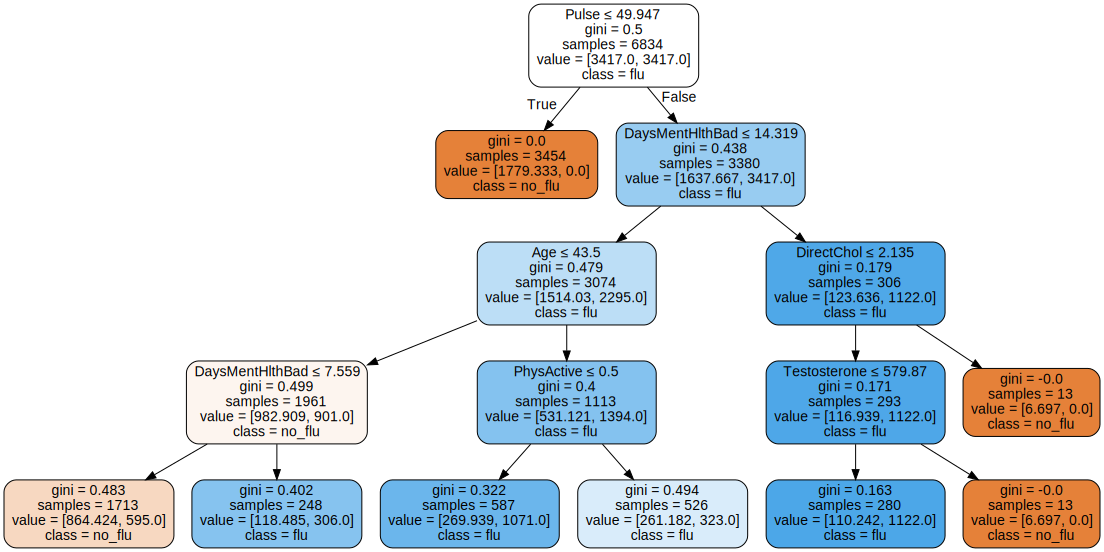

In [24]:
### fancy models that solve the problem
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as tree

clf = DecisionTreeClassifier(random_state=0, class_weight='balanced', max_depth=4)
print(np.mean(cross_val_score(clf, X_train, y_train, cv=5, scoring='balanced_accuracy')))
clf = clf.fit(X_train, y_train)
print(expected_score(clf, X_test.to_numpy(), y_test.to_numpy()))

dot_data = tree.export_graphviz(clf, out_file=None, 
                      feature_names=X_train.columns.to_list(),  
                      class_names=['no_flu', 'flu'],  
                      filled=True, rounded=True,
                      special_characters=True)
graph = graphviz.Source(dot_data)
graph 

## On evaluation

### AUROC

As mentioned abbove, we will use the accuracy scores for each class and for the whole dataset, as well as the AUROC score from Kaggle platform. You can coimpute AUROC locally (e.g. on your train/validation set) by calling the relevant scikit learn function:

In [ ]:
###AUROC locally

#score = roc_auc_score(real_labels, predicted_labels)

#real_labels: the ground truth (0 or 1)
#predicted_labels: labels predicted by your algorithm (0 or 1)



### Accuracy (per class)

Below there is a function that will be handy for your models. It computes the accuracy per-class, based on a model you pass as parameter and a dataset (split to x/y)

In [ ]:
def extended_score(model, x_test, y_test):
    overall = 0
    class_0 = 0
    class_1 = 0
    for i in range(100):
        sample = np.random.choice(len(x_test), len(x_test))
        x_sub_test = x_test[sample]
        y_sub_test = y_test[sample]
        
        overall += model.score(x_sub_test, y_sub_test)
        class_0 += model.score(x_sub_test[y_sub_test==0], y_sub_test[y_sub_test==0])
        class_1 += model.score(x_sub_test[y_sub_test==1], y_sub_test[y_sub_test==1])

    return pd.Series([overall / 100., 
                      class_0 / 100.,
                      class_1 / 100.],
                      index=['overall accuracy', 'accuracy on class 0', 'accuracy on class 1'])

In [ ]:
#same job as before, but faster?

score = lambda model, x_val, y_val: pd.Series([model.score(x_val, y_val), 
                                                 model.score(x_val[y_val==0], y_val[y_val==0]),
                                                 model.score(x_val[y_val==1], y_val[y_val==1])], 
                                                index=['overall accuracy', 'accuracy on class 0', 'accuracy on class 1'])

## Solution extraction for Kaggle

Make sure that you extract your solutions (predictions) in the correct format required by Kaggle

## Step 3: Conclusions

Highlight at the end of your notebook, which were the top-3 approaches that produced the best scores for you. That is, provide a table with the scores you got (on the AUROC score you get from Kaggle) and make sure that you judge these in relation to your work on the training set